# Testing
---
This notebook will be my testing method until one test becomes too big to handle

In [1]:
from qiskit.quantum_info import Pauli,SparsePauliOp,Statevector
from colorama import Fore

In [16]:
psi = Statevector.from_int(4,dims=8)
psi

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [8]:
pl = Pauli('ZZI')

print(pl.to_matrix(sparse=True))

  (0, 0)	(1+0j)
  (1, 1)	(1+0j)
  (2, 2)	(-1+0j)
  (3, 3)	(-1+0j)
  (4, 4)	(-1+0j)
  (5, 5)	(-1+0j)
  (6, 6)	(1+0j)
  (7, 7)	(1+0j)


In [10]:
H_cut = SparsePauliOp(Pauli('ZZI'))+ SparsePauliOp(Pauli('ZIZ'))

print("H_cut is")
print(H_cut)
print("The sparse representation of H_cut is")
print(H_cut.to_matrix(sparse=True))

H_cut is
SparsePauliOp(['ZZI', 'ZIZ'],
              coeffs=[1.+0.j, 1.+0.j])
The sparse representation of H_cut is
  (0, 0)	(2+0j)
  (1, 1)	0j
  (2, 2)	0j
  (3, 3)	(-2+0j)
  (4, 4)	(-2+0j)
  (5, 5)	0j
  (6, 6)	0j
  (7, 7)	(2+0j)


In [18]:
psi.expectation_value(H_cut).real

-2.0

## Quantum Annealer

In this part of the notebook, we try the Ocean framework, to work with quantum annealers 

In [44]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite

In [ ]:
# Coefficients of the quadratic term elements (squared or products)
J = {(0,1):1, (0,2):1}
# Coefficients of the linear terms
h = {}
problem = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
print("The problem we are going to solve is:")
print(problem)


The problem we are going to solve is:
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0}, {(1, 0): 1.0, (2, 0): 1.0}, 0.0, 'SPIN')


In [ ]:
# You need to have an access token configured
sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(problem, num_reads=10)
print("The solutions that we have obtained are")
print(result)

The solutions that we have obtained are
   0  1  2 energy num_oc. chain_.
0 -1 +1 +1   -2.0       4     0.0
1 +1 -1 -1   -2.0       6     0.0
['SPIN', 2 rows, 10 samples, 3 variables]


In [4]:
result.info['timing']['qpu_access_time']

16583.76

Using `dimod` we can also solve binary problems without having to rewrite them in the QUBO or Ising model form. To test this we will solve the next minimization problem:

\begin{aligned}   
        \text{Minimize } \quad -5x_0+3x_1-2x_2\\
        \text{Subject to }\qquad \qquad x_0 + x_2 \leq 1,\\
        3x_0 − x_1 + 3x_2 \leq 4 \\
        \vec{x} \in \{0,1\}^3
    \end{aligned}

In [42]:
from dimod import Binary

x0 = Binary("x0")
x1 = Binary("x1")
x2 = Binary("x2")

# Define the problem (objective and constraints)
blp = dimod.ConstrainedQuadraticModel()

blp.set_objective(-5*x0+3*x1-2*x2)
blp.add_constraint(x0 + x2 <= 1, "First constraint")
blp.add_constraint(3*x0 -x1 + 3*x2 <= 4, "Second constraint")

print(f"Variables: {blp.variables}")
print(f"Objective: {blp.objective}")
print(f"Our constraints are: {blp.constraints}")

solver = dimod.ExactCQMSolver()

sol = solver.sample_cqm(blp)

# This calculates even non feasible solutions
print('Solutions')
print(sol,'\n')

# We want the best feasible solution. We can filter by its feasibility and take the first element
feas_sol = sol.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

Variables: Variables(['x0', 'x1', 'x2'])
Objective: ObjectiveView({'x0': -5.0, 'x1': 3.0, 'x2': -2.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'})
Our constraints are: {'First constraint': Le(ConstraintView({'x0': 1.0, 'x2': 1.0}, {}, 0.0, {'x0': 'BINARY', 'x2': 'BINARY'}), 1.0), 'Second constraint': Le(ConstraintView({'x0': 3.0, 'x1': -1.0, 'x2': 3.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'}), 4.0)}
Solutions
  x0 x1 x2 energy num_oc. is_sat. is_fea.
6  1  0  1   -7.0       1 arra...   False
2  1  0  0   -5.0       1 arra...    True
7  1  1  1   -4.0       1 arra...   False
3  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       1 arra...    True
0  0  0  0    0.0       1 arra...    True
5  0  1  1    1.0       1 arra...    True
1  0  1  0    3.0       1 arra...    True
['INTEGER', 8 rows, 8 samples, 3 variables] 

Best Solution
Variables: {'x0': 1, 'x1': 0, 'x2': 0}, Cost = -5.0


However, using this we dont use quantum annealers, to do that we can transform the problem to a QUBO using Ocean functions.

In [ ]:
qubo, invert = dimod.cqm_to_bqm(blp,lagrange_multiplier = 5)

# print(qubo) # Quite ugly output

sampler = EmbeddingComposite(DWaveSampler())
result = sampler.sample(qubo,num_reads=10)

print('Solutions')
print(result)

Solutions
  slack_v050645ea8f4d4fa59dfae269a2016c91_0 ... x2 energy num_oc. chain_.
0                                         0 ...  1   -2.0       1     0.0
1                                         0 ...  0   -2.0       1     0.0
2                                         0 ...  0    0.0       1     0.0
3                                         0 ...  0    0.0       2     0.0
4                                         0 ...  1    3.0       2     0.0
5                                         1 ...  0    5.0       1     0.0
6                                         1 ...  1    8.0       1     0.0
7                                         1 ...  1   21.0       1     0.0
['BINARY', 8 rows, 10 samples, 7 variables]


By using the QA we get the solutions from the transformed problem, we can obtain the solutions from the original problem by untransforming

In [55]:
samples = []
occurrences = []

for s in result.data():
    samples.append(invert(s.sample))
    occurrences.append(s.num_occurrences)
    sampleset = dimod.SampleSet.from_samples_cqm(samples,blp,num_occurrences=occurrences)
    
print("The solutions to the original problem are")
print(sampleset,'\n')

feas_sol = sampleset.filter(lambda s: s.is_feasible)
print(Fore.RED+'Best Solution'+Fore.RESET)
print(f'Variables: {feas_sol.first.sample}, Cost = {feas_sol.first.energy}')

The solutions to the original problem are
  x0 x1 x2 energy num_oc. is_sat. is_fea.
2  1  0  0   -5.0       1 arra...    True
3  1  0  0   -5.0       2 arra...    True
7  1  1  1   -4.0       1 arra...   False
0  0  0  1   -2.0       1 arra...    True
1  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       2 arra...    True
6  0  0  1   -2.0       1 arra...    True
5  0  0  0    0.0       1 arra...    True
['INTEGER', 8 rows, 10 samples, 3 variables] 

Best Solution
Variables: {'x0': 1, 'x1': 0, 'x2': 0}, Cost = -5.0


As we can see, we get the same solutions, with the observation that we get the best solution ($x_0=1, x_1=x_2=0$) more than any other answer.

---
Using properties from the `dimod` package, we can change the multiple parameters that define the QA, maybe even obtaining better solutions for the problems. However, the scope of this work is not to use QA, rather **Quantum Approximate Optimization Algorithm** or **QAOA** to run the simulation on a general purpose QPU. We will be using **Qiskit** again.

## QAOA

In [3]:
from qiskit import QuantumCircuit

As we will be using this disposition of gates multiple times, we create a function

In [20]:
def interaction_term(qc: QuantumCircuit, phi, control, target)->QuantumCircuit:
    """
    Builds the gate from the interaction term in the Ising Hamiltonian
    
    Args:
        `qc`: The quantum circuit to be added
        `phi`: The parameter $\phi$ from the optimization
        `control`: The position of the control qubit
        `target`: The position of the target qubit
    
    Returns:
        The modified QuantumCircuit
    
    """
    
    qc.cx(control,target)
    qc.rz(phi*2,target)
    qc.cx(control,target)
    
    return qc

This is a test to write a QAOA circuit for a simple Hamiltonian $H_1=𝑍_1𝑍_3 + 𝑍_0𝑍_2 − 2𝑍_1 + 3𝑍_2$ with $𝑝 = 1$ (AKA one layer). As we only have 1 layer we will need 2 parameters: $\beta$ and $\gamma$

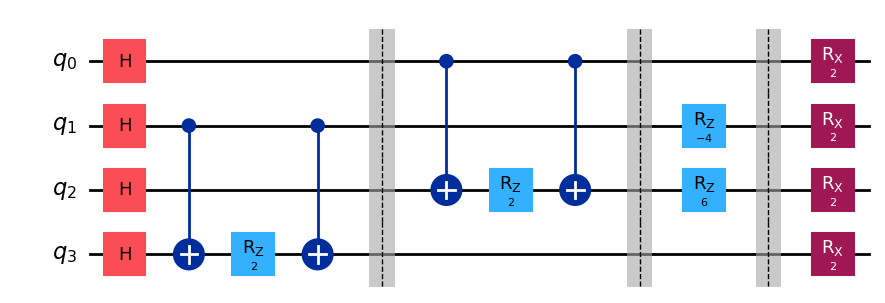

In [28]:
qcirc = QuantumCircuit(4)
beta = 1
gamma = 1

# Prepare the state |+>
for i in range(4):
    qcirc.h(i)

# H1, interaction terms
qcirc = interaction_term(qcirc,beta,1,3)
qcirc.barrier()
qcirc = interaction_term(qcirc,beta,0,2)
qcirc.barrier()

# H1, independent terms
qcirc.rz(-4*beta,1)
qcirc.rz(6*beta,2)

qcirc.barrier()

# H0, X rotations
for i in range(4):
    qcirc.rx(2*gamma,i)

qcirc.draw('mpl')